# Eigen Faces (Clustering and Unsupervised Learning)

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from PIL import Image
import glob
from sklearn.decomposition import PCA
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib
import uuid
import re
import networkx as nx

## 1. Load images

In [139]:
students = [cv2.imread(file) for file in glob.glob(
    "www.usfca.edu/sites/default/files/images/headshots/*.jpg")]
students = [student[..., ::-1] for student in students]
students = [cv2.resize(student, (150, 150)) for student in students]


In [140]:
items = os.listdir("www.usfca.edu/sites/default/files/images/headshots/")

student_names = []
for names in items:
    if names.endswith(".jpg"):
        student_names.append(names[13:])

Text(0.5,0.98,'Students')

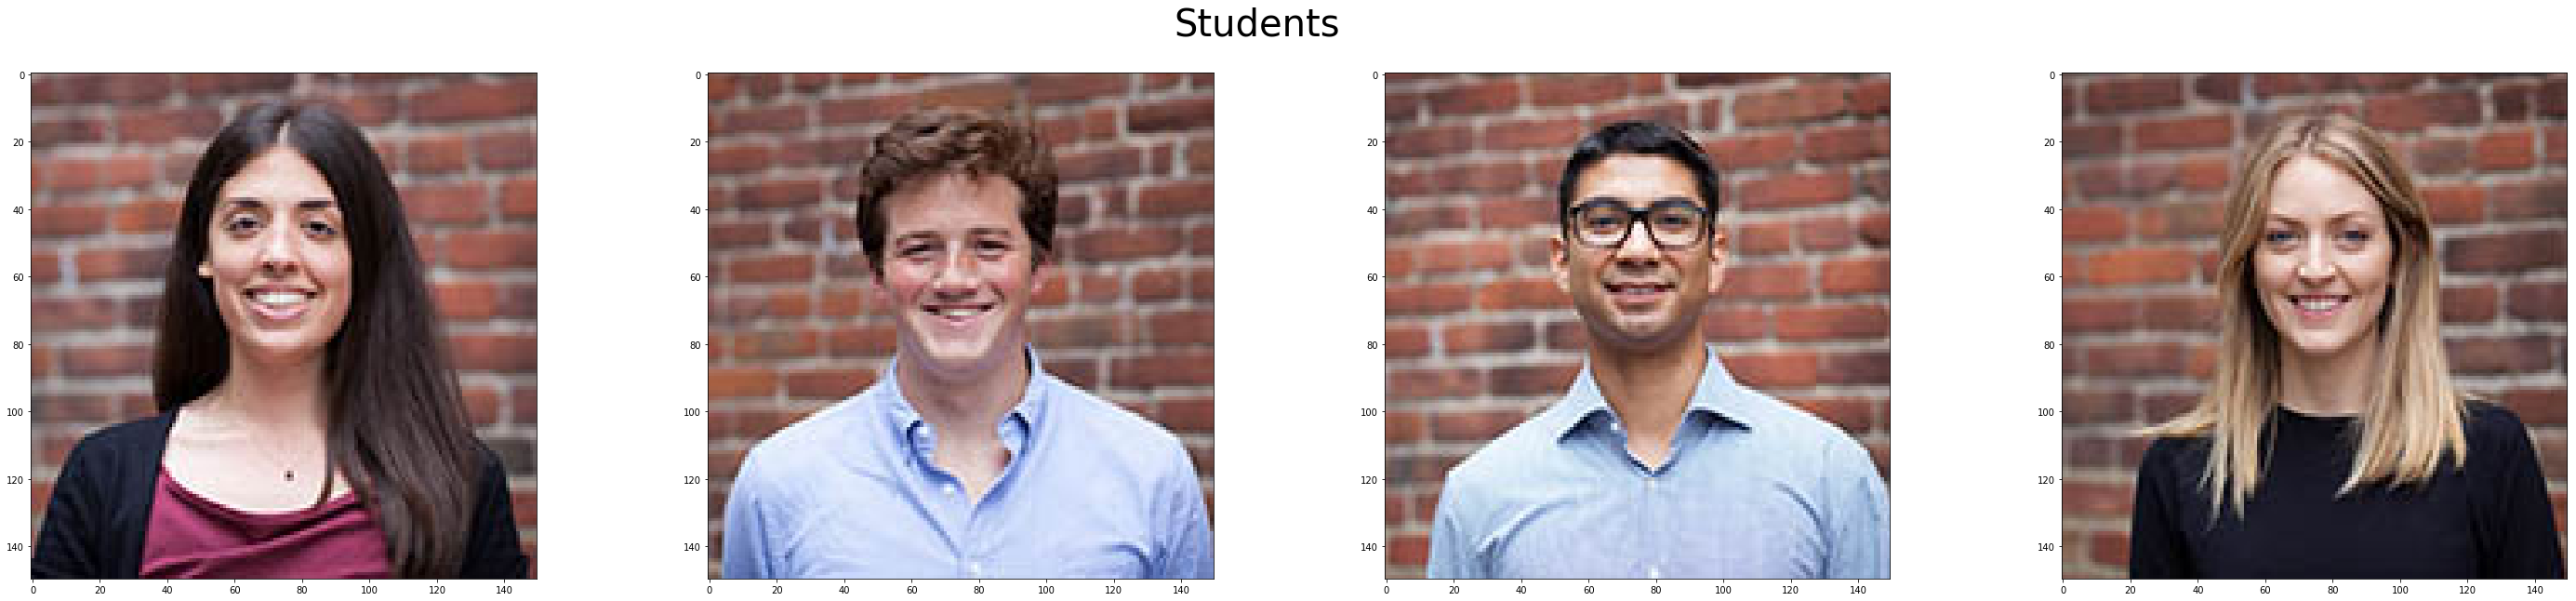

In [141]:
fig, axes = plt.subplots(1, 4, figsize=(50, 10))
for i in range(4):
    axes[i].imshow(students[i])
plt.suptitle('Students', fontsize=40)

Text(0.5,0.98,'Faculty')

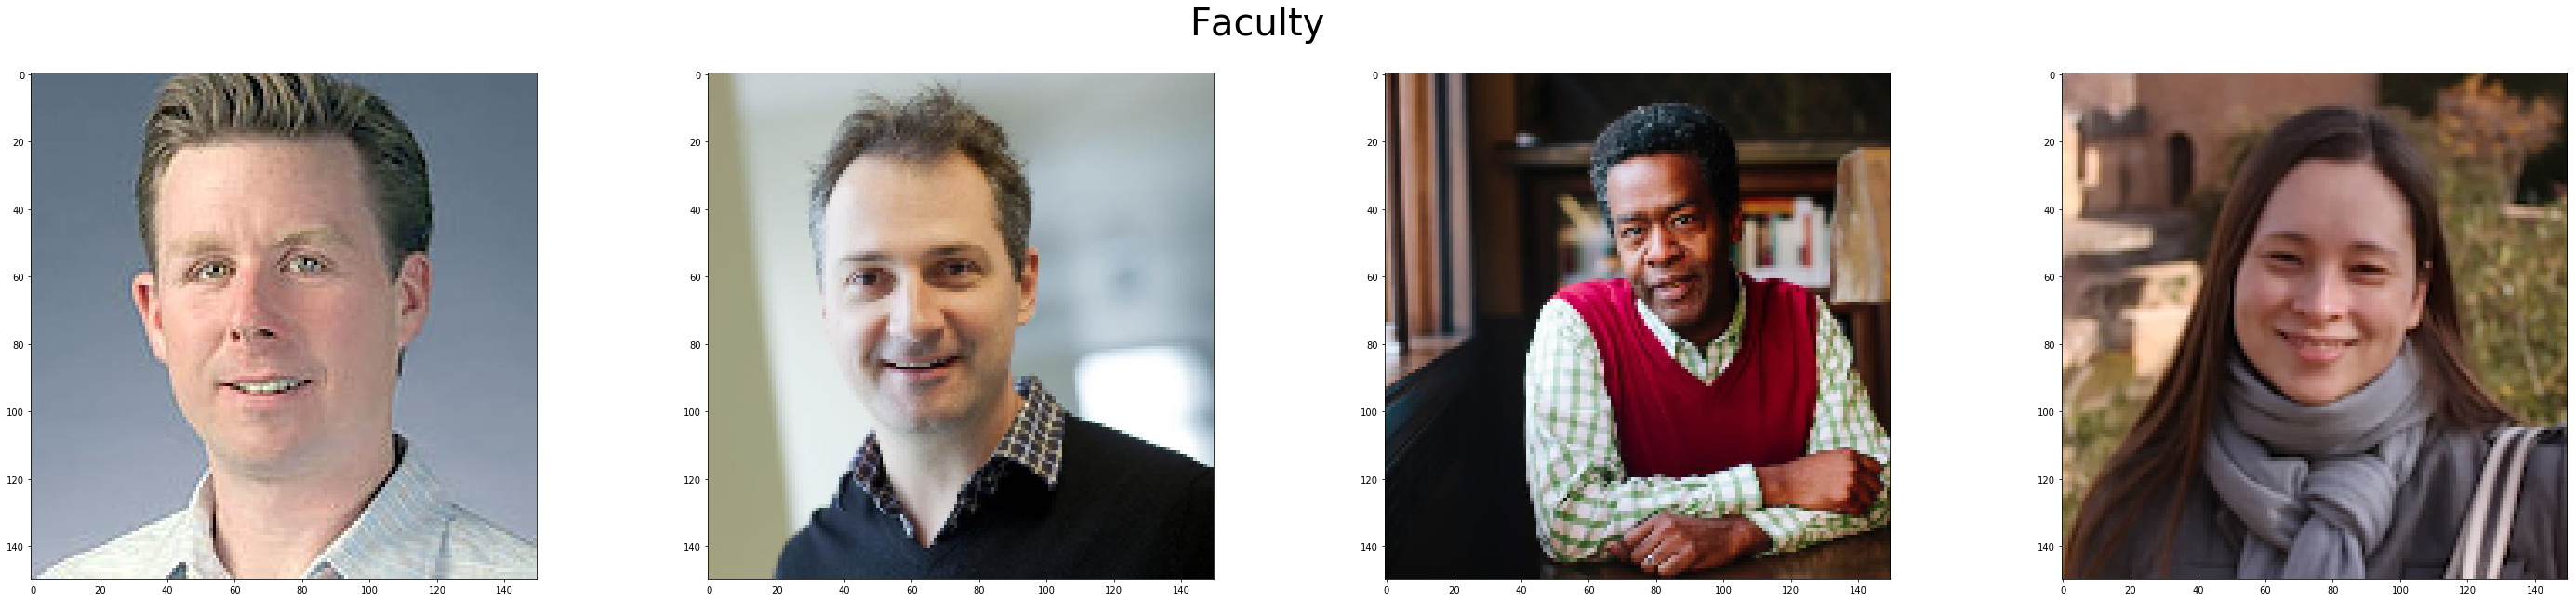

In [142]:
faculty = [cv2.imread(file) for file in glob.glob(
    "www.usfca.edu/sites/default/files/styles/student_profile_500x500/public/images/headshots/*.jpg")]
faculty = [f[..., ::-1] for f in faculty]

# Resize the images to make them 100 x 100
faculty = [cv2.resize(f, (150, 150)) for f in faculty]

fig, axes = plt.subplots(1, 4, figsize=(50, 10))
for i in range(4):
    axes[i].imshow(faculty[i])
plt.suptitle('Faculty', fontsize=40)

In [143]:
items = os.listdir("www.usfca.edu/sites/default/files/styles/student_profile_500x500/public/images/headshots/")

faculty_names = []
for names in items:
    if names.endswith(".jpg"):
        faculty_names.append(names)
faculty_names       

['2147483669_u_devlin_s.jpg',
 '6442451308_u_mikeb_photo.jpg',
 'brizan-david-guy.jpg',
 'engle_sophie.jpg',
 'francis-lyon_patricia.jpg',
 'hamrick-jeff1.jpg',
 'interian-yannet.jpg',
 'intrevado-paul.jpg',
 'nick-ross.jpg',
 'parr_terrence.jpg',
 'stevens-nathaniel.jpg',
 'thomas-rachel.jpg',
 'uminsky_david_0.jpg',
 'wilson-james.jpg',
 'woodbridge-diane-03.jpg']

## 2. Crop and align images

In [144]:
def facechop(image_list, output_dir, file_names):
    '''
    Extract faces from the images present in the input directory and save the cropped images in the output directory
    input:
    input_dir: path to the directory where the input images are present
    fnames: list of filenames in the input_dir for which face extraction needs to be done
    output_dir: path to the directory where the output images need to be saved

    return: None
    Note: 
    Output may or may not be of the same size
    There can be multiple version of cropped image. Pick the best crop
    '''
    os.makedirs(output_dir, exist_ok=True)
    facedata = "haarcascade_frontalface_default.xml"
    for j in range(len(image_list)):
        cascade = cv2.CascadeClassifier(facedata)
        face = cascade.detectMultiScale(image_list[j])
        faces = []
        for i, f in enumerate(face):
            x, y, w, h = f
            sub_face = image_list[j][y:y + h, x:x + w]
            cv2.imwrite(output_dir + '/' + str(i) + '_' + file_names[j] , sub_face)
    return None

In [145]:
facechop(students, 'student_images', student_names)

Text(0.5,0.98,'Students')

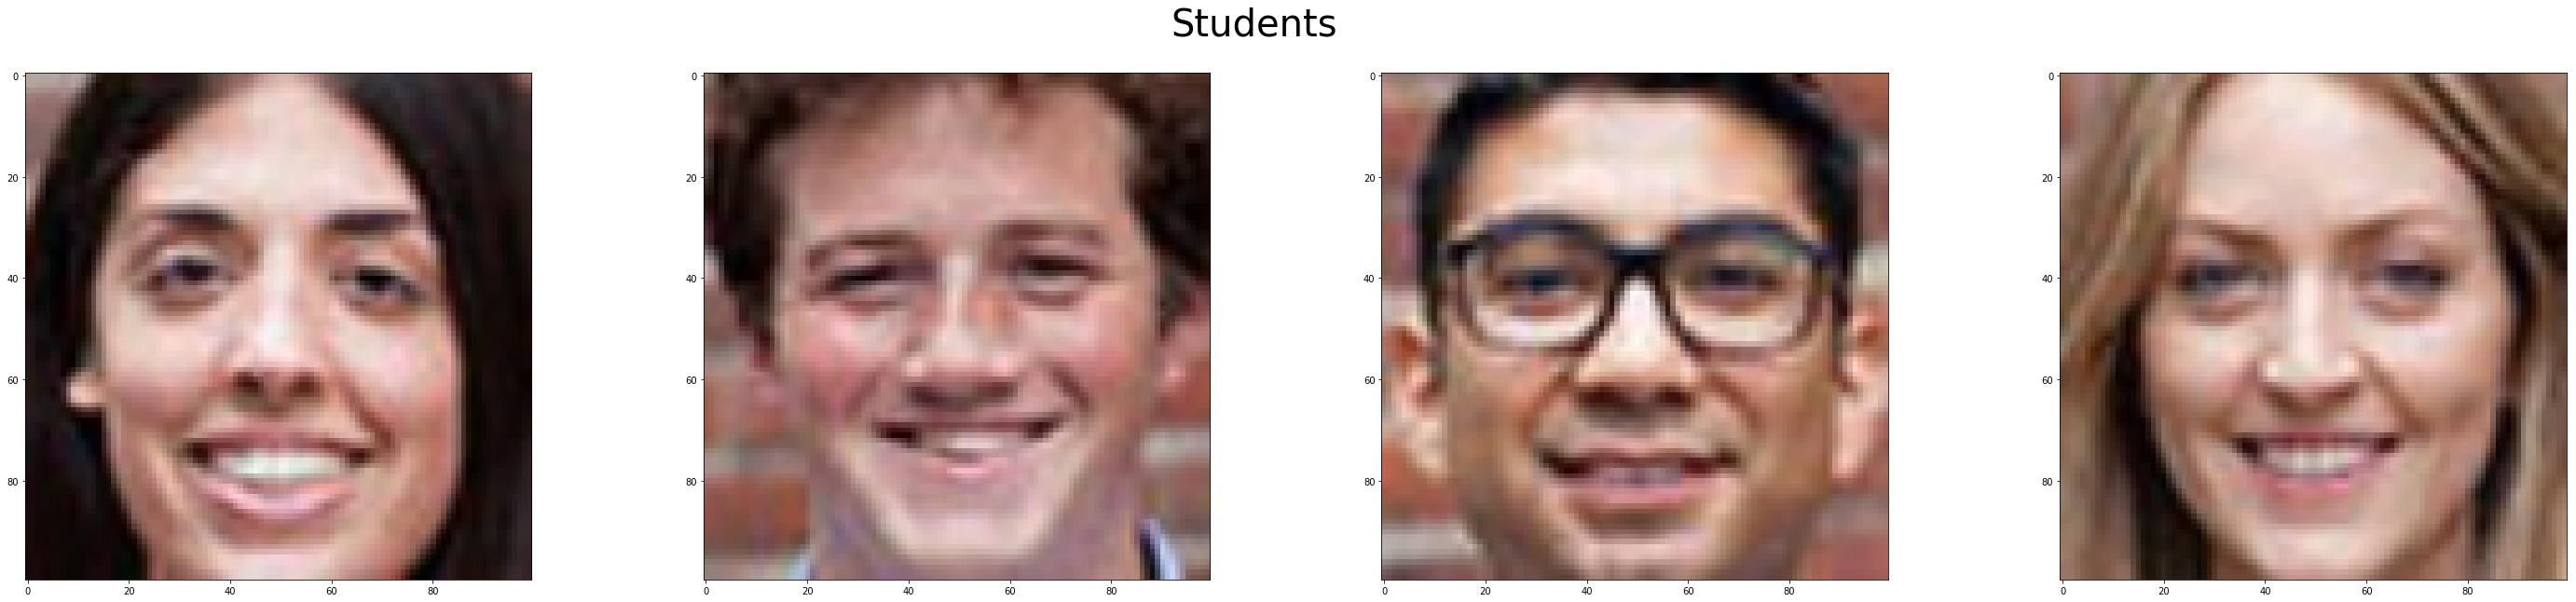

In [156]:
students = [cv2.imread(file) for file in glob.glob("student_images/*.jpg")]
students = [cv2.resize(student, (100, 100)) for student in students]
fig, axes = plt.subplots(1, 4, figsize=(50, 10))
for i in range(4):
    axes[i].imshow(students[i])
plt.suptitle('Students', fontsize=40)

In [157]:
facechop(faculty, 'faculty_images', faculty_names)

In [158]:
# Aligning the faculty images:
faculty = [cv2.imread(file) for file in glob.glob("faculty_images/*.jpg")]

shape_predictor_path = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor and the face aligner
fa = FaceAligner(predictor, desiredFaceWidth=50)
os.makedirs("faculty-faces_aligned", exist_ok=True)
for j in range(len(faculty)):
    img = faculty[j]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 2)
    # loop over the face detections
    for i, rect in enumerate(rects):
        # extract the ROI of the *original* face, then align the face
        # using facial landmarks
        (x, y, w, h) = rect_to_bb(rect)
        faceOrig = imutils.resize(img[y:y + h, x:x + w], width=50)
        faceAligned = fa.align(img, gray, rect)
        cv2.imwrite(
            "faculty-faces_aligned/" + str(i) + '_' + faculty_names[j],
            faceAligned)

Text(0.5,0.98,'Faculty')

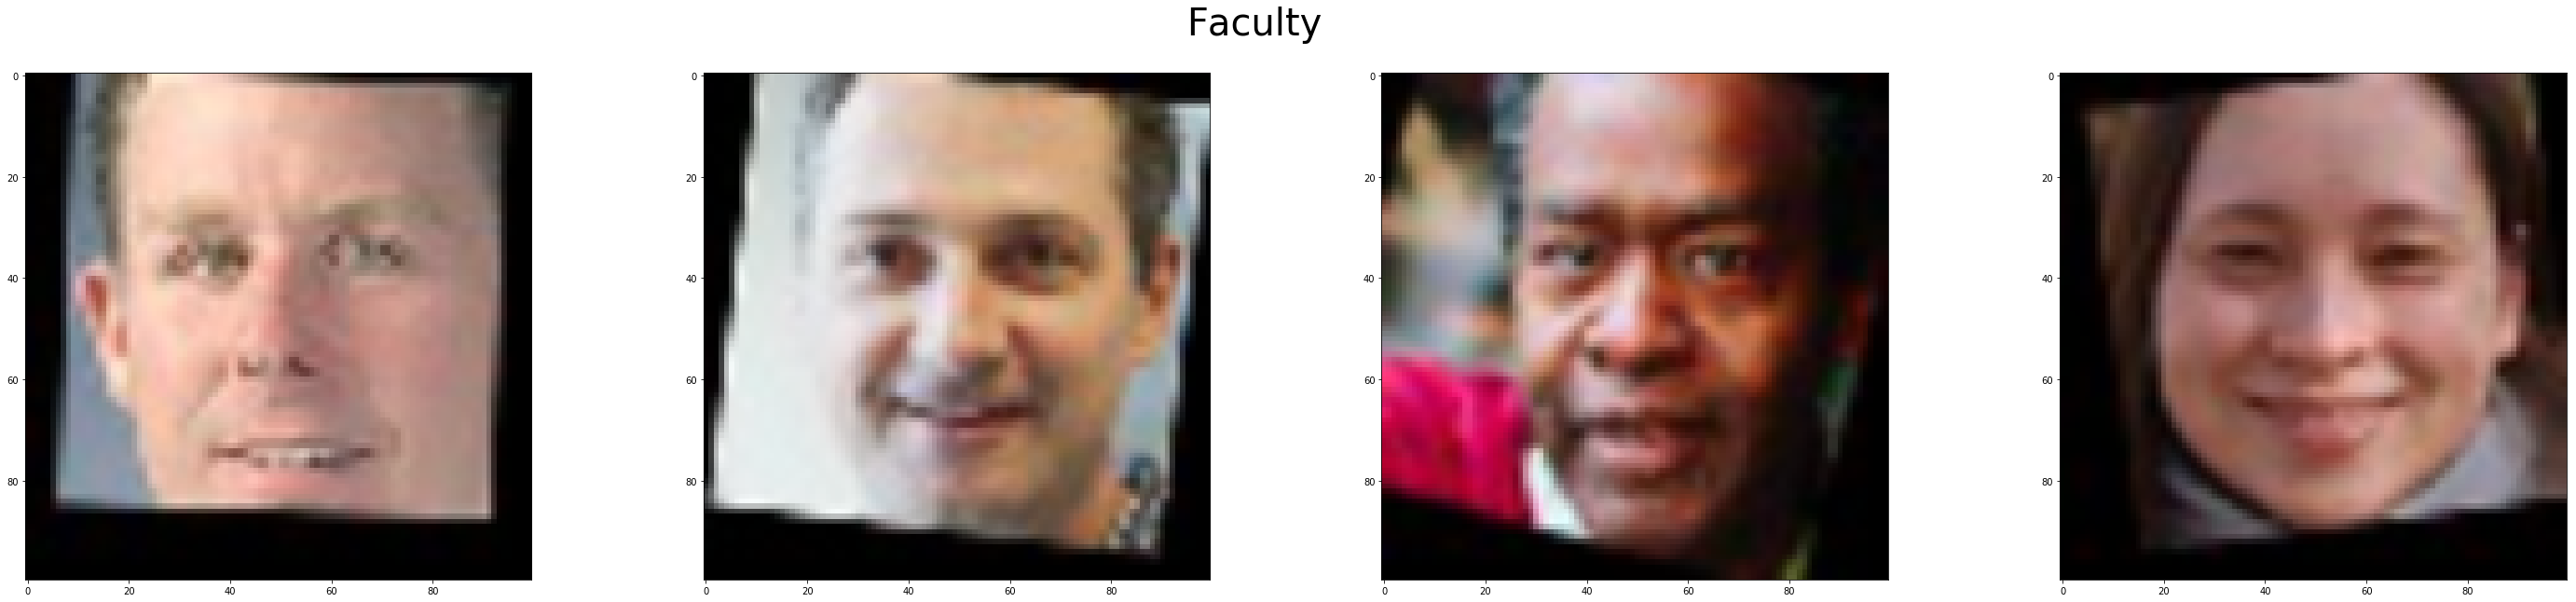

In [159]:
faculty = [cv2.imread(file) for file in glob.glob("faculty-faces_aligned/*.jpg")]
faculty = [cv2.resize(f, (100, 100)) for f in faculty]
fig, axes = plt.subplots(1, 4, figsize=(50, 10))
for i in range(4):
    axes[i].imshow(faculty[i])
plt.suptitle('Faculty', fontsize=40)

## 3. PCA

In [160]:
def normalise(x):
    """
    Normalize the images so as to have pixel values between 0 and 1
    """
    xmin = min(x)
    xmax = max(x)
    return (x-xmin)/(xmax-xmin)

In [161]:
def pca_analysis(image_list):
    """
    1. Flatten the images
    2. Stack them to form a matrix with columns representing the images
    3. Find the mean face and subtract it from all the columns
    4. fit_transform pca on this matrix
    5. Plot the 4 eigen faces
    6. Print the variance explained by these faces
    7. Return the list comtaining all the eigen faces and the mean image
    """
    image_list = [img.flatten() for img in image_list]
    X = np.vstack(image_list)
    X = X.transpose()
    X.shape
    mean_image = X.mean(1)
    X = X - mean_image.transpose().reshape(30000, 1)
    plt.imshow(normalise(mean_image).reshape(100, 100, 3))
    plt.title('Mean Image')
    pca = PCA()
    students_pca = pca.fit_transform(X)
    students_pca = students_pca.transpose()
    fig, axes = plt.subplots(1, 4, figsize=(50, 10))
    for i in range(4):
        axes[i].imshow(normalise(students_pca[i]).reshape(100, 100, 3))
        axes[i].set_title(str(pca.explained_variance_ratio_[i]), fontsize = 30)
    plt.suptitle('Eigen Faces', fontsize=40)
    print('Variance explained: ' + str(pca.explained_variance_ratio_[0:4]))
    return(students_pca, mean_image)

### Students

Variance explained: [ 0.21700761  0.09904501  0.06357952  0.04440714]


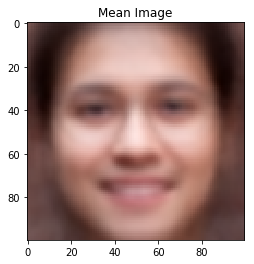

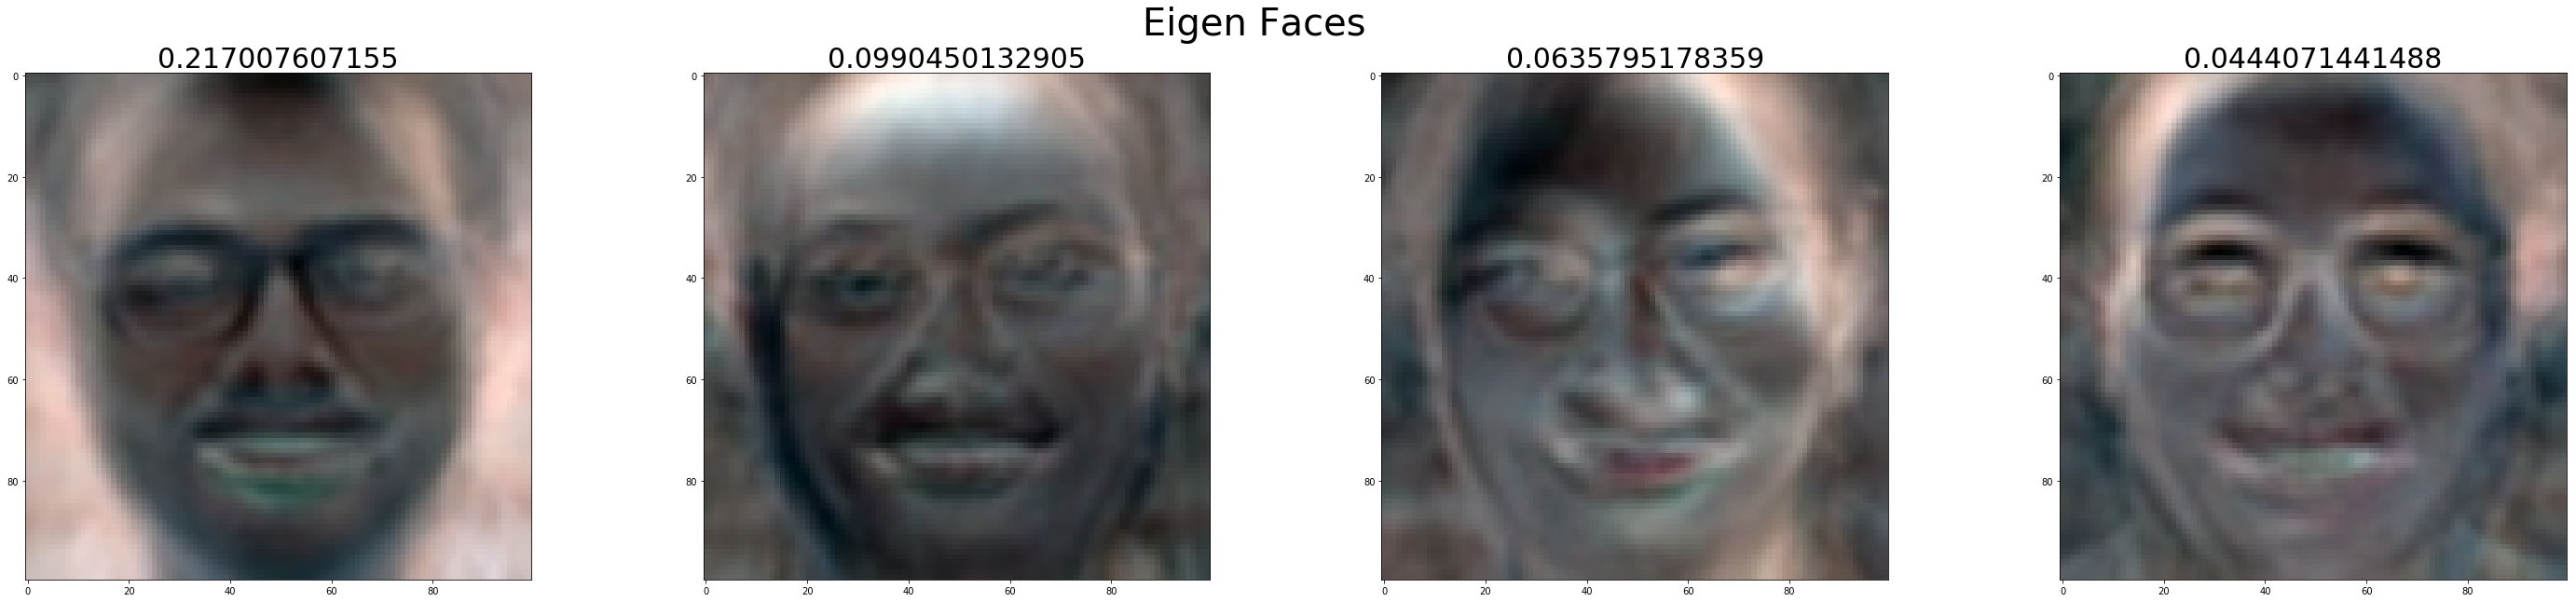

In [162]:
students_pca, student_mean_image = pca_analysis(students)

Thus the top 4 eigen faces explain the following about of variance:
`0.21700761,  0.09904501,  0.06357952,  0.04440714`

### Faculty

Variance explained: [ 0.27908827  0.23128592  0.1053851   0.06995367]


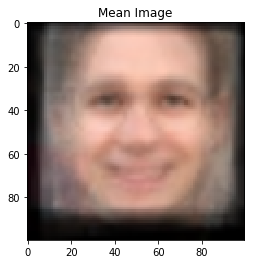

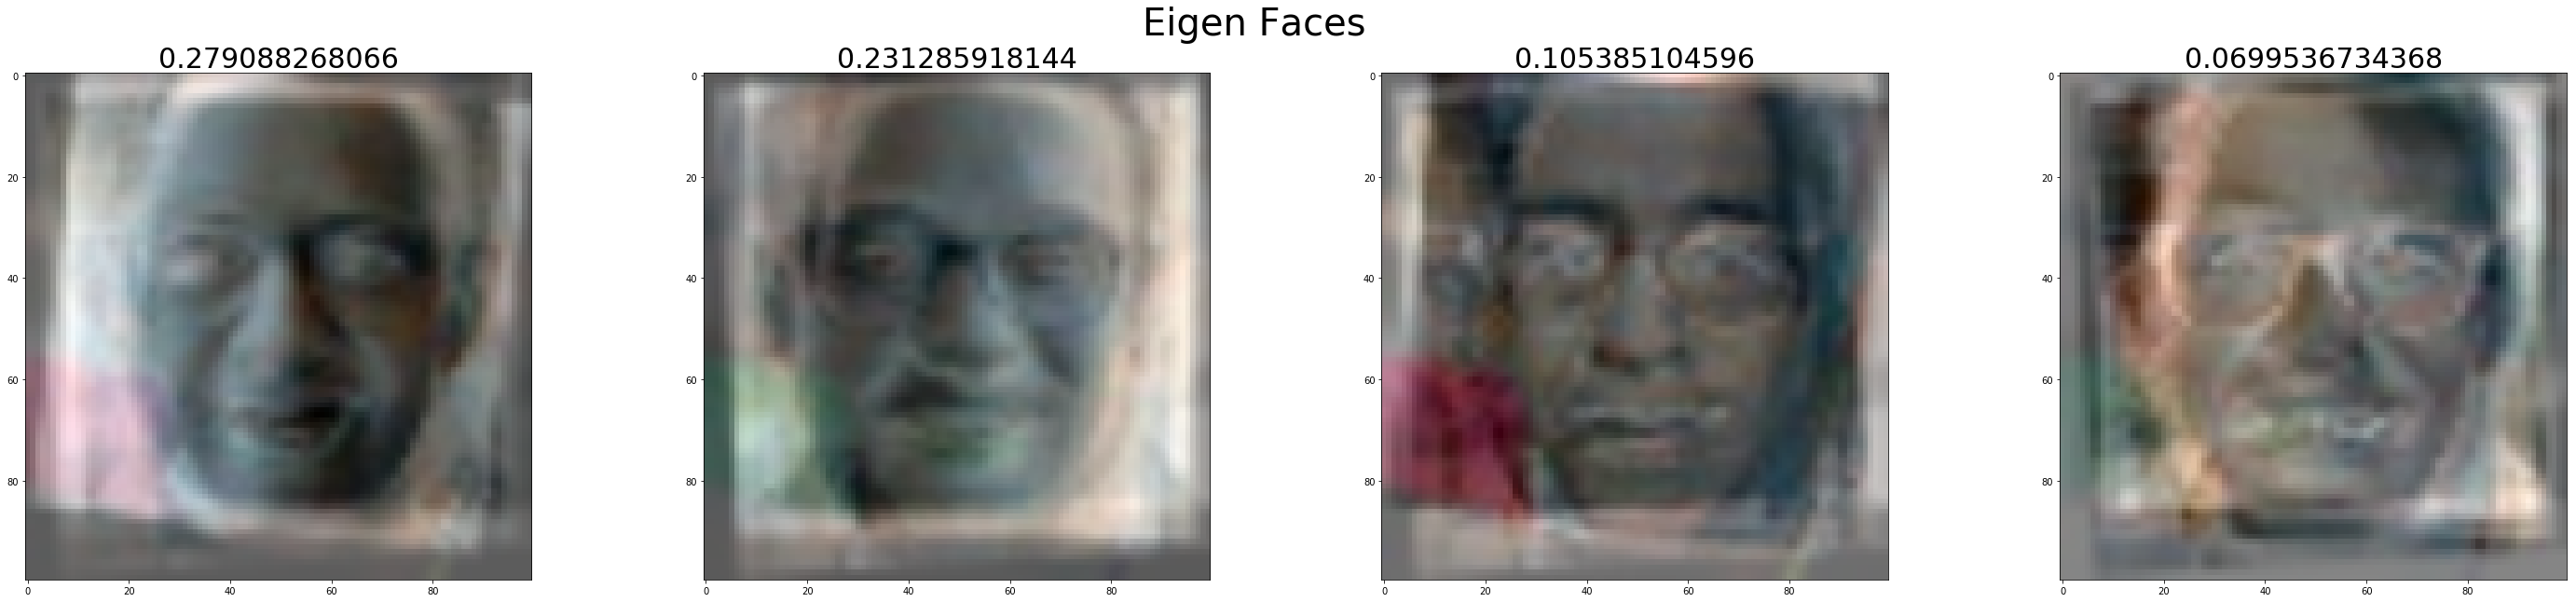

In [163]:
faculty_pca, faculty_mean_image = pca_analysis(faculty)

Thus the top 4 eigen faces explain the following about of variance:
`0.27908827, 0.23128592, 0.1053851, 0.06995367`

## 4. Reconstructing Images

In [164]:
my_img = cv2.imread('student_images/0_doshi-neerja.jpg')

my_img_adjusted = (cv2.resize(my_img, (100, 100)).flatten() -
                   student_mean_image).reshape(30000, 1)
# print(my_img_adjusted.shape)

weights = np.linalg.lstsq(students_pca.transpose(), my_img_adjusted)[0]
print(weights[:4])

# students_pca[0].shape

[[ 0.06335683]
 [ 0.08577033]
 [ 0.11945209]
 [-0.09989431]]


The weights corresponding to the top 4 eigen faces are `0.06335683, 0.08577033, 0.11945209, -0.09989431`.

In [165]:
def plot_reconstructed(weights, students_pca, n_components):
    """
    Recontructs the face given weights and number of components.
    """
    recon = np.zeros(())
    for i in range(n_components):
        recon = recon + float(weights[i]) * students_pca[i].reshape(30000, 1)
    return recon

Text(0.5,0.98,'Reconstructed')

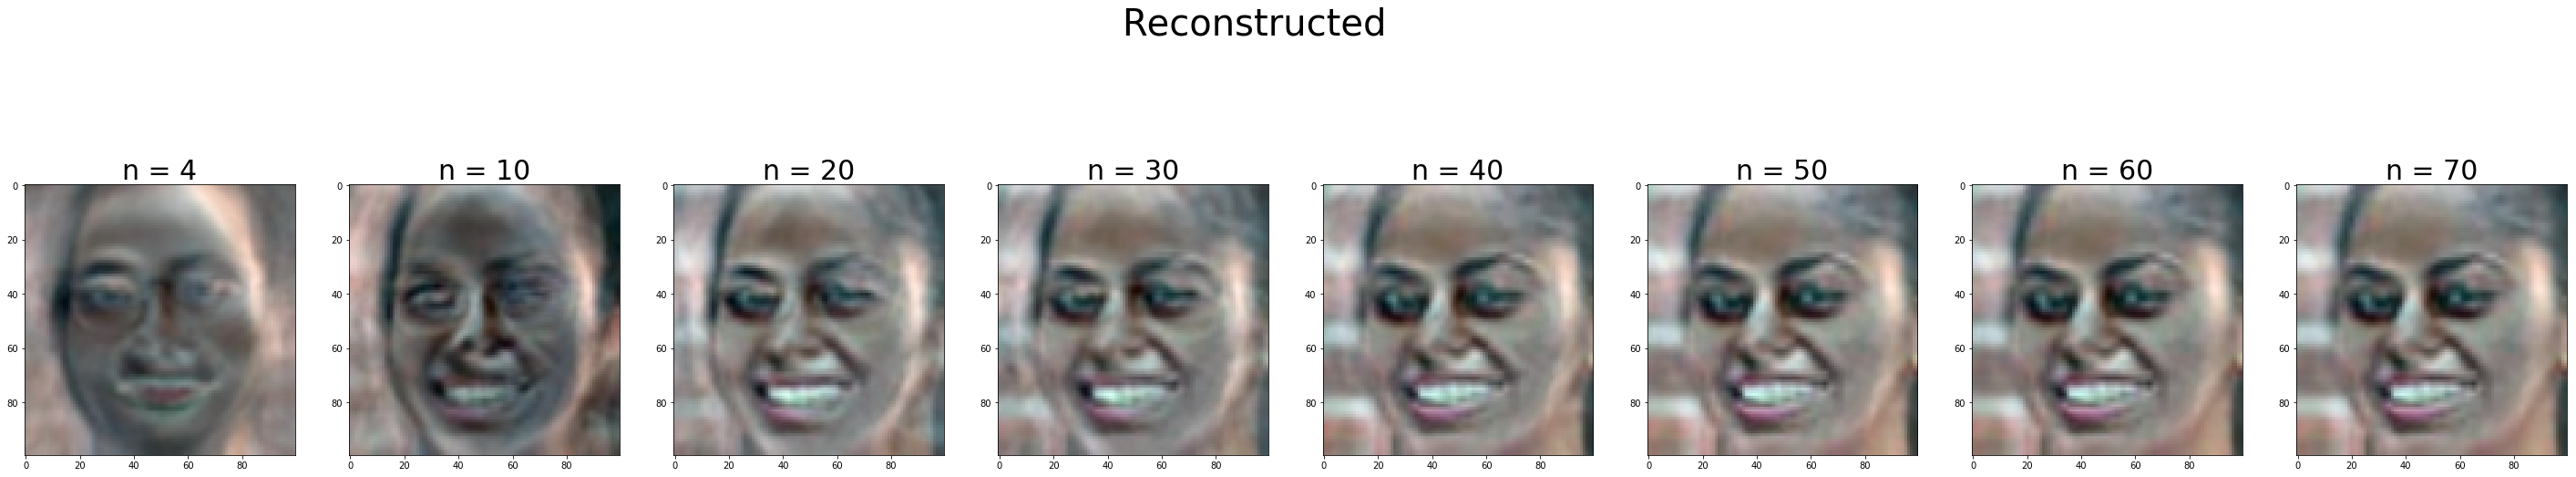

In [166]:
recon = []
components = [4, 10, 20, 30, 40, 50, 60, 70]
for i in range(len(components)):
    recon.append(plot_reconstructed(weights, students_pca, components[i]))

fig, axes = plt.subplots(1, len(components), figsize=(50, 10))
for i in range(len(components)):
    axes[i].imshow(normalise(recon[i]).reshape(100, 100, 3))
    axes[i].set_title('n = ' + str(components[i]), fontsize=30)
plt.suptitle('Reconstructed', fontsize=40)

In [167]:
james = cv2.imread('faculty-faces_aligned/0_wilson-james.jpg')

james_adjusted = (cv2.resize(james, (100, 100)).flatten() -
                  faculty_mean_image).reshape(30000, 1)
# print(james_adjusted.shape)

weights = np.linalg.lstsq(faculty_pca.transpose(), james_adjusted)[0]
print(weights[:4])

# faculty_pca[0].shape

[[-0.0078527 ]
 [ 0.18526387]
 [-0.19933153]
 [ 0.1593994 ]]


The weights corresponding to the top 4 eigen faces are ` -0.0078527, 0.18526387, -0.19933153, 0.1593994`.

Text(0.5,0.98,'Reconstructed')

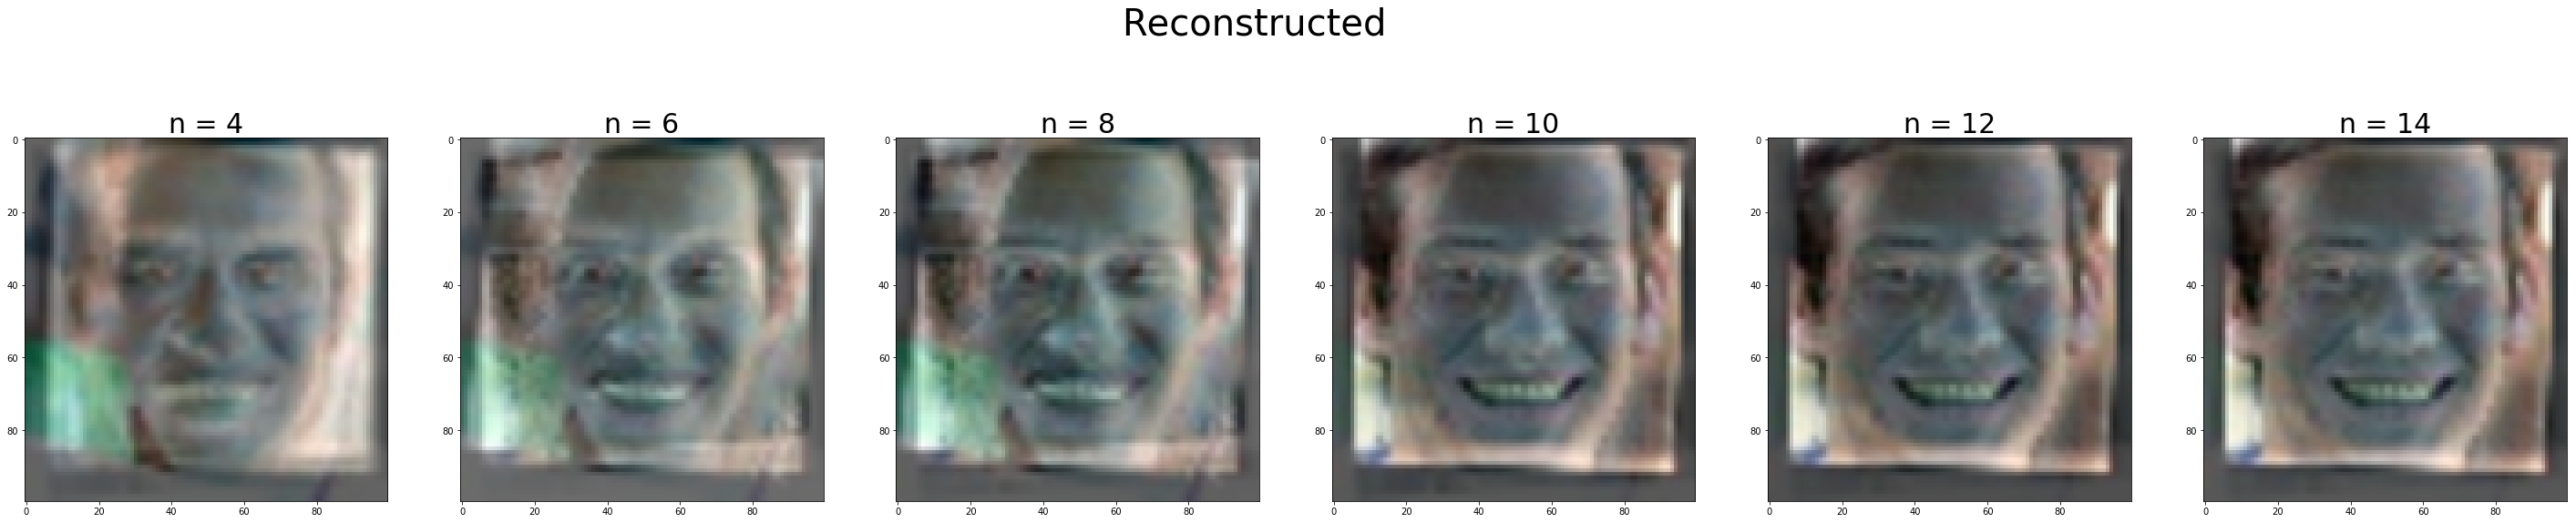

In [168]:
recon = []
components = [4, 6, 8, 10, 12,14]
for i in range(len(components)):
    recon.append(plot_reconstructed(weights, faculty_pca, components[i]))

fig, axes = plt.subplots(1, len(components), figsize=(50, 10))
for i in range(len(components)):
    axes[i].imshow(normalise(recon[i]).reshape(100, 100, 3))
    axes[i].set_title('n = ' + str(components[i]), fontsize=30)

plt.suptitle('Reconstructed', fontsize=40)

## 5. Similarity

For this part, I have used cosine similarity to compute similarities between faces of students with each other and the faces of the faculty with each other.

### Student - student similarity

In [169]:
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.metrics import jaccard_similarity_score

In [172]:
recon = []

students = [cv2.imread(file) for file in glob.glob("student_images/*.jpg")]
for i in range(len(students_pca)):
    img = students[i]
    img_adjusted = (cv2.resize(img, (100, 100)).flatten() -
                   student_mean_image).reshape(30000, 1)
    weights = np.linalg.lstsq(students_pca.transpose(), img_adjusted)[0]
    components = [20]
    recon.append(plot_reconstructed(weights, students_pca,20))

sim = pd.DataFrame(cosine_similarity(np.array(recon)[:,:,0]))
sim.columns = list(pd.Series(student_names).apply(lambda x: x[:-4]))
sim.index = list(pd.Series(student_names).apply(lambda x: x[:-4]))
sim = sim.stack().reset_index()
sim.columns = ['S1', 'S2', 'similarity']

In [173]:
# Setting a threshold of 0.7
sim_thresh = sim.loc[(sim['similarity'] > 0.7)
                           & (sim['S1'] != sim['S2'])]

In [174]:
sim_thresh.head()

,S1,S2,similarity
48,avgerinou-danai,shaw-mathew,0.709638
477,chen-si,li-qian,0.735254
502,chen-si,song-amber,0.793560
537,csiszar-chris,grover-prince_0,0.756058
566,csiszar-chris,pellerin-taylor,0.738176


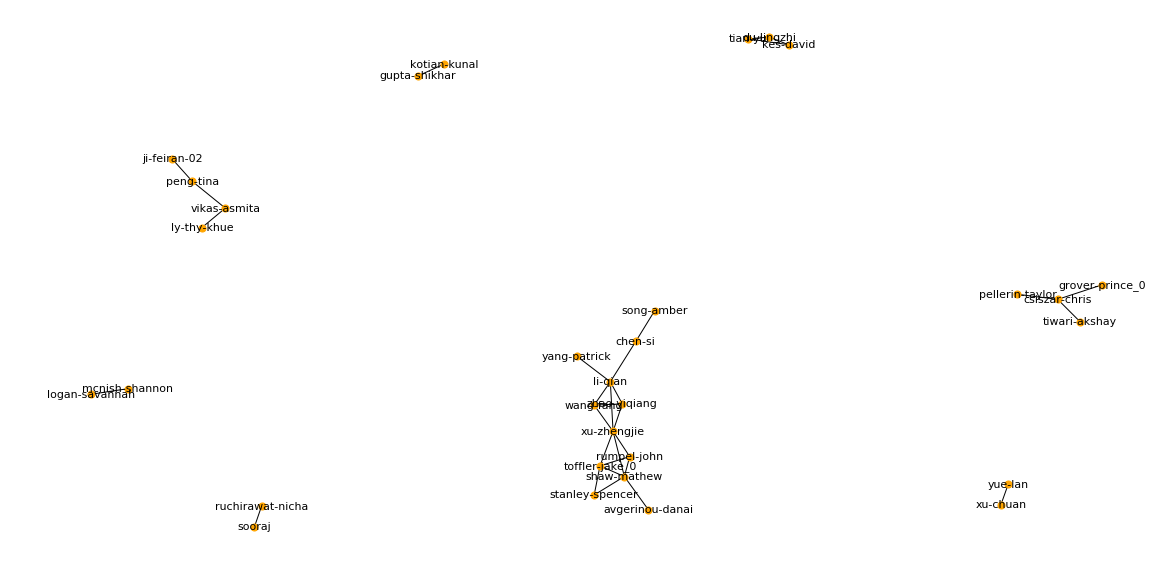

In [175]:
G = nx.from_pandas_edgelist(sim_thresh, 'S1', 'S2')
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
nx.draw(
    G,
    with_labels=True,
    node_color='orange',
    node_size=50,
    edge_color='black',
    linewidths=1,
    font_size=11,
    ax=axes,
    pos=nx.fruchterman_reingold_layout(G))

In [176]:
sim[sim['S1'] == 'doshi-neerja'].sort_values(by = 'similarity', ascending= False)[0:2]

,S1,S2,similarity
684,doshi-neerja,doshi-neerja,1.000000
710,doshi-neerja,mahar-sara,0.608064


### Faculty

In [177]:
recon = []

faculty = [cv2.imread(file) for file in glob.glob("faculty-faces_aligned/*.jpg")]
for i in range(len(faculty_pca)):
    img = faculty[i]
    img_adjusted = (cv2.resize(img, (100, 100)).flatten() -
                   faculty_mean_image).reshape(30000, 1)
    weights = np.linalg.lstsq(faculty_pca.transpose(), img_adjusted)[0]
    components = [14]
    recon.append(plot_reconstructed(weights, faculty_pca,14))
sim = pd.DataFrame(cosine_similarity(np.array(recon)[:,:,0]))
sim.columns = list(pd.Series(faculty_names).apply(lambda x: x[:-4]))
sim.index = list(pd.Series(faculty_names).apply(lambda x: x[:-4]))

In [178]:
sim = sim.stack().reset_index()
sim.columns = ['S1', 'S2', 'similarity']

In [179]:
sim_thresh = sim.loc[(sim['similarity'] > 0.40)
                           & (sim['S1'] != sim['S2'])]

In [180]:
sim_thresh.head()

,S1,S2,similarity
44,brizan-david-guy,woodbridge-diane-03,0.436453
56,engle_sophie,thomas-rachel,0.416221
57,engle_sophie,uminsky_david_0,0.518134
66,francis-lyon_patricia,interian-yannet,0.602668
94,interian-yannet,francis-lyon_patricia,0.602668


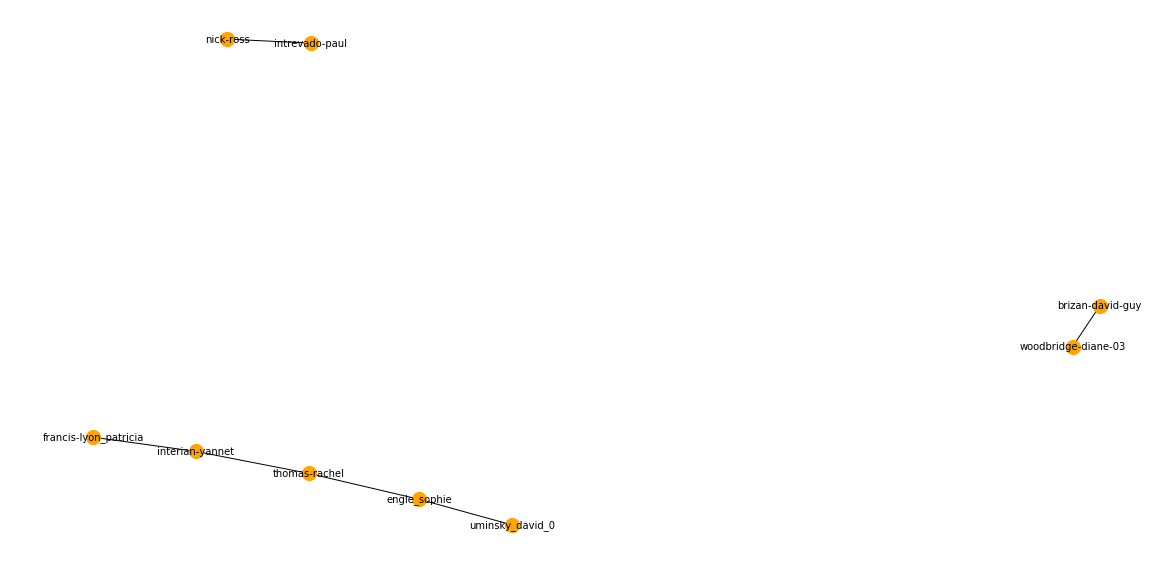

In [181]:
G = nx.from_pandas_edgelist(sim_thresh, 'S1', 'S2')
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
nx.draw(
    G,
    with_labels=True,
    node_color='orange',
    node_size=200,
    edge_color='black',
    linewidths=1,
    font_size=10,
    ax=axes,
    pos=nx.fruchterman_reingold_layout(G))

In [182]:
sim[sim['S1'] == 'wilson-james'].sort_values(by = 'similarity', ascending= False)[0:2]

,S1,S2,similarity
208,wilson-james,wilson-james,1.000000
203,wilson-james,nick-ross,0.233342


James' face seems most similar to Nick's